# Generating graph data

In [47]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interactive, fixed
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Graph generator

In [2]:
def generate_graph(num_nodes, num_clusters, num_features, dist_params, p, q):
    """
    Method to generate a graph with clusters, where different distributions generate node attributes
    
    Params:
        num_nodes: Total nodes in the graph (int)
        num_clusters: Number of clusters in the graph (int)
        num_features: Length/dimensionality of node attribute vectors (int)
        dist_params: The parameters of the distributions for each clsuter. List of length num_clusters with (μ, σ) tuple
        p: Cluster level edge probability
        q: Graph level edge probability
    """
    # init
    g = nx.empty_graph()
    A = np.zeros((num_nodes, num_nodes))

    # randomly assign clusters
    clusters = {
        i : np.random.choice(np.arange(num_clusters)) 
        for i in range(num_nodes)
    }
    
    cluster_groups = {}
    for key, value in sorted(clusters.items()):
        cluster_groups.setdefault(value, []).append(key)

    # use corresponding distributions to generate attributes
    node_attrs = {
        i: np.random.normal(loc=dist_params[c][0], scale=dist_params[c][1], size=num_features)
        for i, c in clusters.items()
    }
    
    # intra-cluster edges
    for _, c_list in cluster_groups.items():
        len_list = len(c_list)
        
        p_intra_cluster = np.abs( np.random.normal(p, 0.1))
        max_edges = ((len_list**2)//2) if len_list < 500 else len_list
        num_intra_cluster_edges = np.int32(p_intra_cluster * max_edges)
        
        for _ in range(num_intra_cluster_edges):
            i = np.random.choice(c_list)
            j = np.random.choice(c_list)
            A[i][j] = 1 # remove self-loops after!!
    
    # other edges
    p_other = np.abs(np.random.normal(q, 0.1))
    num_other_edges = np.int32(p_other * (num_nodes))

    for _ in range(num_other_edges):
        i = np.random.choice(np.arange(num_nodes))
        j = np.random.choice(np.arange(num_nodes))
        A[i][j] = 1
    
    g = nx.from_numpy_array(A)
    nx.set_node_attributes(g, node_attrs, 'x')
    
    return g, clusters


def generate_and_draw(num_nodes, num_clusters, num_features, dist_params, p, q):
    G, clusters = generate_graph(num_nodes, num_clusters, num_features, dist_params, p, q)

    colours = ['red', 'blue', 'green', 'orange', 'pink', 'yellow', 'gray']
    plt.figure(figsize=(10,7))
    nx.draw(G, node_color=[colours[c] for c in clusters.values()])
    plt.show()

In [ ]:
dist_params = [
    (5, 0.9),
    (3, 0.4),
    (-1, 0.5),
    (0,0.1)
]

generate_and_draw(
    num_nodes=2000,
    num_clusters=4,
    num_features=2,
    dist_params=dist_params,
    p=0.7,
    q=0.5
);

In [3]:
dist_params = [
    (5, 0.9),
    (3, 0.4),
    (-1, 0.5),
    (0,0.1)
]

interactive_plot = interactive(generate_and_draw, 
                        num_nodes=(10,150),
                        num_clusters=fixed(4),
                        num_features=fixed(2),
                        dist_params=fixed(dist_params),
                        p=(0.,1.0),
                        q=(0.,1.0)
                    )
interactive_plot

interactive(children=(IntSlider(value=80, description='num_nodes', max=150, min=10), FloatSlider(value=0.5, de…

In [149]:
print('{:6s} {:6s}'.format('Nodes', 'Time'))

for N in [10, 50, 100, 500, 1000, 5000, 10000, 15000]:
    start = time.time()

    generate_graph(
        num_nodes=N,
        num_clusters=4,
        num_features=2,
        dist_params=dist_params,
        p=0.75,
        q=0.1
    )

    end = time.time()
    print('{:<6d} {:<6.3f}s'.format(N, end-start))

Nodes  Time  
10     0.002 s
50     0.008 s
100    0.030 s
500    1.003 s
1000   6.164 s
5000   1.251 s
10000  4.204 s
15000  10.321s


***
## New generator

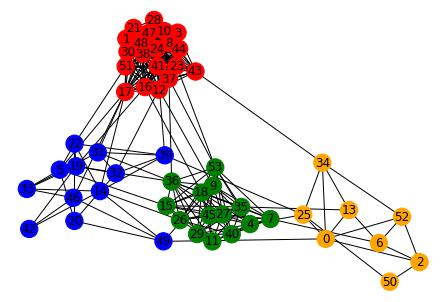

In [71]:
generator_params = [
    (20, 0.9),
    (12, 0.3),
    (14, 0.8),
    (8,0.5)
]

G = nx.empty_graph()

for i, (n,p) in enumerate(generator_params):
    g = nx.fast_gnp_random_graph(n, p)
    nx.set_node_attributes(g, i, 'label')
    G = nx.disjoint_union(G,g)

N = G.number_of_nodes()
E = G.number_of_edges()

random_edges = [
    (np.random.randint(N), np.random.randint(N)) 
    for i in range(30)
]

G.add_edges_from(random_edges)

node_mapping = dict(zip(G.nodes(), sorted(G.nodes(), key=lambda k: np.random.random())))
G = nx.relabel_nodes(G, node_mapping)

colours_shuffled = ['red', 'blue', 'green', 'orange', 'pink', 'yellow', 'gray']
labels_shuffled = nx.get_node_attributes(G, 'label')

A = nx.adj_matrix(G, nodelist=sorted(G.nodes()))
new_G = nx.from_scipy_sparse_matrix(A)
nx.set_node_attributes(new_G, labels_shuffled, 'label')

nx.draw(new_G, with_labels=True, 
        node_color=[colours_shuffled[labels_shuffled[i]] for i in np.arange(N)],
#         labels = labels_shuffled
       )

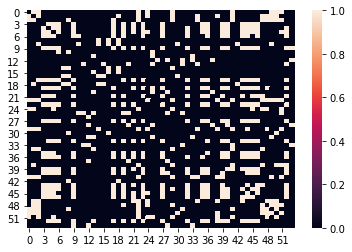

In [69]:
sns.heatmap(nx.adj_matrix(new_G).todense())